In [4]:
from typing import Tuple
from math import *
import numpy as np
import control as ct
from scipy.spatial.transform import Rotation as Rot

# Defining classes
class Celestrial:
  def __init__(self,
               mass:float,                            # [kg]
               pos:Tuple[float,float,float],          # [km]
               ang_vel:float):     # [rad/s]
    self.mass = mass
    self.x,self.y,self.z = pos
    self.w = ang_vel
    self.X0 = None

class JWST:
  def __init__(self,
               mass:float,
               pos:Tuple[float,float,float]):
    self.mass = mass
    self.x,self.y,self.z = pos
    self.X0 = None

  # @staticmethod
  # # dynamic of JWST in rotating frame
  # def JWST_update_nondim(t,X,u,params):
  #   pi_1 = params.get('pi_1')
  #   pi_2 = params.get('pi_2')

  #   sigma = np.sqrt(np.sum(np.square([X[0] + pi_2, X[2] , X[4]])))
  #   psi = np.sqrt(np.sum(np.square([X[0] - pi_1, X[2] , X[4]])))

  #   return np.array([
  #    X[1],
  #    -pi_1/sigma**3*(X[0] + pi_2) - pi_2/psi**3*(X[0] - pi_1) + 2*X[3] + X[0] + u[0],
  #    X[3],
  #    -pi_1/sigma**3*X[2] - pi_2/psi**3*X[2] - 2*X[1] + X[2] + u[1],
  #    X[5],
  #    -pi_1/sigma**3*X[4] - pi_2/psi**3*X[4] + u[2]
  #   ])
  @staticmethod
  def JWST_update_nondim(t, X, u, params):
    pi_1 = params.get('pi_1')
    pi_2 = params.get('pi_2')

    x, xdot, y, ydot, z, zdot = X
    ux, uy, uz = u

    r1 = np.sqrt((x + pi_2)**2 + y**2 + z**2)
    r2 = np.sqrt((x - pi_1)**2 + y**2 + z**2)

    dxdt = xdot
    dxdotdt = 2*ydot + x - pi_1*(x + pi_2)/r1**3 - pi_2*(x - pi_1)/r2**3 + ux
    dydt = ydot
    dydotdt = -2*xdot + y - pi_1*y/r1**3 - pi_2*y/r2**3 + uy
    dzdt = zdot
    dzdotdt = -pi_1*z/r1**3 - pi_2*z/r2**3 + uz

    return np.array([dxdt, dxdotdt, dydt, dydotdt, dzdt, dzdotdt])


  @staticmethod
  # Output of the system
  def JWST_output(t,X,u,params):
    return X
  
class ThreeBodySystem:                     
  def __init__(self,
               m_Sun:float = 1.98847e30,
               m_Earth:float = 5.9722e24,
               m_JWST:float = 6500,
               Omega:float = 2 * pi / 31556926,   # Angular Velocity in rad/s of the rotating frame [rad/s] 
               r_12:float = 1.495978707e8):          # Earth-Sun mean distance [km]
    self.G = 6.674e-20                            # Gravitational constant [km^3/kg/s^2]
    self.m_Sun = m_Sun
    self.m_Earth = m_Earth                        # Characteristic Mass in [kg]
    self.M = m_Earth + m_Sun
    self.mu = self.G*self.M
    self.pi_1 = m_Sun / (m_Earth + m_Sun)
    self.pi_2 = m_Earth / (m_Earth + m_Sun)
    self.Omega = Omega
    self.r_12 = r_12                              # Characteristic Length in [km]
    self.t_C =  np.sqrt(r_12**3/self.mu)          # Characteristic Time in [s]
    self.V_C = r_12/self.t_C                      # Characteristic Velocity in [km/s]
    # self.Gm1 = self.G*m_Earth
    # self.Gm2 = self.G*m_Sun
    self.w_Earth = 7.292115e-5                     # Earth's Rotation speed in rad/s in  ECEF
    self.n = 1.991e-7                              # rad/s mean motion of the Sun-Earth line in Ecliptic

    # Instantiate 3 bodies as components
    self.Sun = Celestrial(mass = m_Sun, pos = (-self.pi_2 ,0,0), ang_vel = 0)
    self.Earth = Celestrial(mass = m_Earth, pos = (self.pi_1 ,0,0), ang_vel = self.w_Earth)
    self.JamesWebb = JWST(mass = m_JWST, pos = (self.Earth.x + 2000000/r_12,0,0))

  @staticmethod
  def RotToFixed(r,W,t):
    Rz = Rot.from_euler('z',W * t,degrees=False)
    return Rz.apply(r)

# Instantiate Three body system and its compositions. 
TB = ThreeBodySystem()

# Set the initial states for JWST
TB.JamesWebb.X0 = np.array([TB.Earth.x + 2000000/TB.r_12,
                            2/TB.V_C,
                            0/TB.r_12,
                            5/TB.V_C,
                            5000/TB.r_12,
                            5/TB.V_C])

# Define parameters used in JWST dynamics
JWST_params = {'pi_1':TB.pi_1,'pi_2':TB.pi_2}

# Define the Input/Output System
JWST_IO = ct.nlsys(TB.JamesWebb.JWST_update_nondim, TB.JamesWebb.JWST_output,
                    states=['x','xdot','y','ydot','z','zdot'], name = 'JWST',
                    inputs=['ux','uy','uz'], outputs=['x','xdot','y','ydot','z','zdot'],
                    params=JWST_params)

# Simulation
n_tc = 20
timepts = np.linspace(0,n_tc,2000)       # Nondimensinal time points
u = [np.zeros_like(timepts),np.zeros_like(timepts),np.zeros_like(timepts)]
response = ct.input_output_response(JWST_IO, timepts=timepts, inputs=u, initial_state=TB.JamesWebb.X0,
                                    solve_ivp_kwargs={'rtol':1e-6,'atol':1e-9}, solve_ivp_method='RK45')
time, outputs, inputs = response.time, response.outputs, response.inputs

# Retrive JWST trajectories in rotation frame and dimentionalize them
x = TB.r_12 * outputs['x']
y = TB.r_12 * outputs['y']
z = TB.r_12 * outputs['z']
xdot = TB.V_C * outputs['xdot']
ydot = TB.V_C * outputs['ydot']
zdot = TB.V_C * outputs['zdot']
t = TB.t_C * time

# Transfer to Fixed Frame
XYZ = TB.RotToFixed(np.array([x,y,z]).T,TB.Omega,t)



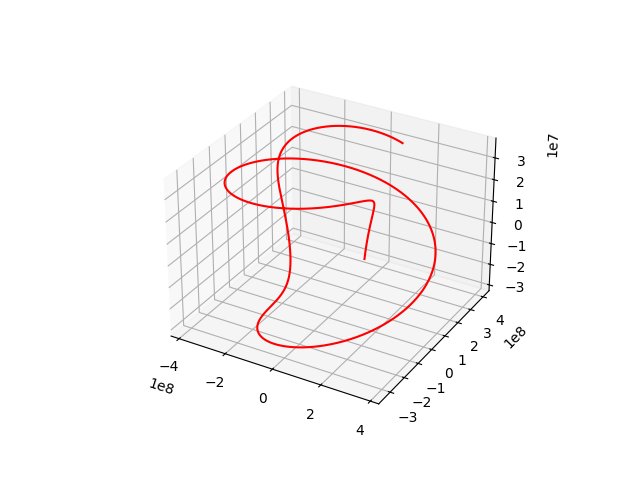

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

In [5]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot(x, y, z, 'r-', lw=1.5)
plt.show()

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D


# Initlize plot object, set limits for axes
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('JWST Trajectory in Rotating Frame (CR3BP)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim3d(x.min() - 500, x.max() + 500)
ax.set_ylim3d(y.min() - 500, y.max() + 500)
ax.set_zlim3d(z.min() - 500, z.max() + 500)

trail, = ax.plot([],[],[],'r-',lw=2)
head, = ax.plot([],[],[],'ro',ms=6)

def init():
  trail.set_data([],[])
  trail.set_3d_properties([])
  head.set_data([],[])
  head.set_3d_properties([])
  return trail, head


def update(i):
  # trail.set_data([x[:i]],[y[:i]])
  # trail.set_3d_properties([z[:i]])
  
  head.set_data([x[i]],[y[i]])
  head.set_3d_properties([z[i]])
  return trail, head

animation_RotatingFrame = FuncAnimation(fig,update,frames=len(t),
                                        interval = 200,blit=False,repeat=False)

plt.show()

